# This notebook offers an empirical application for the presented theory

In [1]:
using Distributions, Statistics, LinearAlgebra, CSV, DataFrames, Plots, StatsPlots, Graphs, GraphPlot, SimpleWeightedGraphs, Random, Colors
trade_flows_vectorised = DataFrame(CSV.File("/Users/jerome/Documents/resolvent-note/simulation-inference/data/30euro_clean.csv";header=false));

Convert this table to a sequence of matrices.

In [2]:
trade_matrices = zeros(12,12,230);
trade_matrices_wm = zeros(Union{Missing,Float64},12,12,230);

for t in 1:size(trade_flows_vectorised)[2]
    k=1;
    for i in 1:12
        indices = filter!(e->e≠i,collect(1:12))
        for j in indices
            trade_matrices_wm[i,j,t] = trade_flows_vectorised[k,t];
            if Missing == typeof(trade_flows_vectorised[k,t])
                trade_matrices[i,j,t] = 0;
            else
                trade_matrices[i,j,t] = trade_flows_vectorised[k,t];
            end
            k += 1;
        end
    end
end

Now find pairs with the smallest maximal deviation (i.e. those that are most constant.)

Make trade matrices with missing data so that you can instruct skipmissing to avoid artificial zeros.

In [23]:
using TimeSeries
spreadmeasure = zeros(66,5);
k=1;
s(v) = abs.(std(skipmissing(v)) / mean(skipmissing(v)));
for i in 1:12
    for j in i+1:12
        #get time series for i and j and then j and i...
        spreadmeasure[k,1] = i;
        spreadmeasure[k,2] = j;
        spreadmeasure[k,3] = s(diff(trade_matrices_wm[i,j,:]));
        spreadmeasure[k,4] = s(diff(trade_matrices_wm[j,i,:]));
        spreadmeasure[k,5] = max(s(diff(trade_matrices_wm[i,j,:])),s(diff(trade_matrices_wm[j,i,:])));
        k = k + 1;
    end
end

In [24]:
small_dev_pairs = spreadmeasure[sortperm(spreadmeasure[:, 5]),1:2][1:7,:]

7×2 Matrix{Float64}:
  6.0  12.0
  9.0  12.0
  8.0  12.0
 11.0  12.0
  1.0   4.0
  3.0   6.0
  2.0   3.0

Find all the time series that are roughly constant to cherry pick a little bit.

In [27]:
using DataFrames, GLM, StatsBase, TimeSeries
ols = lm(@formula(x3 ~ 1), permutedims(trade_flows_vectorised))
r2(ols)

-2.220446049250313e-16

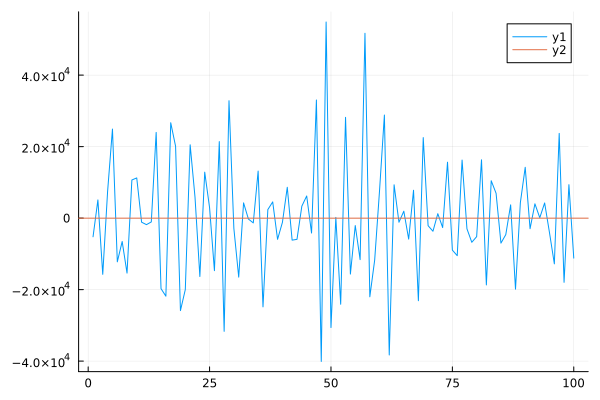

In [78]:
using TimeSeries
pv = diff(trade_matrices_wm[3,8,100:200]);
plot(pv)
hline!([mean(skipmissing(pv))])

In [79]:
mean(pv)

-12.441600000000472

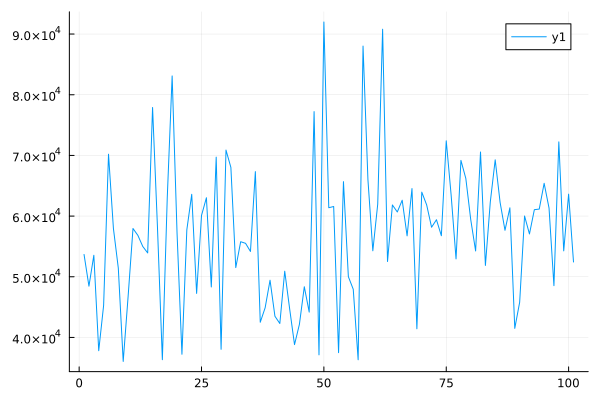

In [80]:
plot(trade_matrices_wm[3,8,100:200])

Construct a time series of centralities to see if there are any that are (roughly) constant.

In [3]:
using Arpack
centralities = zeros(size(trade_flows_vectorised)[2],12)
custom_centralities = zeros(size(trade_flows_vectorised)[2],12)
for i in 1:size(trade_flows_vectorised)[2]
    centralities[i,:] = eigenvector_centrality(SimpleDiGraph(trade_matrices[:,:,i]))'
    custom_centralities[i,:] = abs.(vec(eigs(trade_matrices[:,:,i]; which=:LM, nev=1)[2]))'
end

In [4]:
ups = eigvecs(trade_matrices[:,:,1],sortby = x -> (-floor(real(x), digits = 6), floor(imag(x), digits = 6)))[:,1]
#real(ups ./ ups[1,1])

12-element Vector{ComplexF64}:
    -0.5333813067095767 + 0.0im
   -0.24113665024523917 + 0.0im
   -0.42385488661128257 + 0.0im
   -0.23912294749929305 + 0.0im
   -0.46792861949945574 + 0.0im
   -0.27381713006142333 + 0.0im
   -0.06692410153733457 + 0.0im
  -0.014711599756018958 + 0.0im
  -0.014009246514408541 + 0.0im
   -0.07738858080089493 + 0.0im
    -0.3401523640806304 + 0.0im
 -0.0027543101959312923 + 0.0im

In [5]:
g = SimpleDiGraph(trade_matrices[:,:,1]);
abs.(vec(eigs(trade_matrices[:,:,1]; which=:LM, nev=1)[2]))
#@functionloc eigenvector_centrality(g)
#eigs(adjacency_matrix(g); which=:LM, nev=1)

12-element Vector{Float64}:
 0.5333813067095768
 0.24113665024523914
 0.42385488661128257
 0.23912294749929286
 0.46792861949945525
 0.27381713006142344
 0.06692410153733475
 0.0147115997560191
 0.01400924651440863
 0.07738858080089507
 0.3401523640806301
 0.0027543101959313643

Plot the centralities over time, with each node being a column in the centralities matrix.

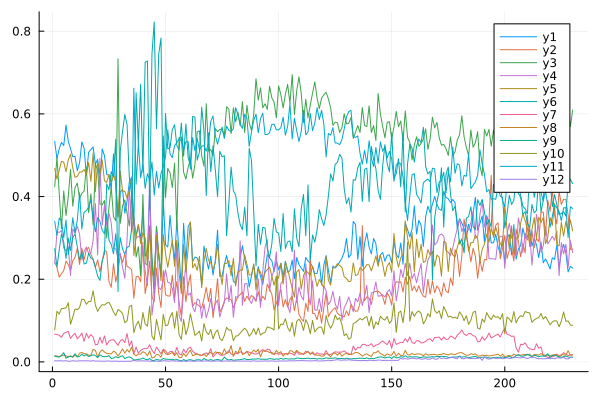

In [7]:
plot(custom_centralities[:,1:12])